In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import datetime as dt
import math
import datetime
from datetime import date, timedelta
from pylab import rcParams
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages
os.chdir('C:\\Users\\omkarp\\Downloads\\python_KTH\\')

In [2]:
df = pd.read_excel('04_AbanCars.xlsx')
df.head()

,Kategori,Date,SynpunktCommonWord,DpFeatureType,Koordinater_X,Koordinater_Y,count,factor
0,Klagomål,2019-01-02,Bil Övergiven,Skrotbilar,"152,883.23","6,578,053.12",1,1
1,Felanmälan,2019-01-03,Bil Övergiven,Skrotbilar,"151,385.68","6,571,275.79",1,1
2,Felanmälan,2019-01-05,Bil Övergiven,Skrotbilar,"145,253.83","6,586,664.83",1,1
3,Felanmälan,2019-01-06,Bil Övergiven,Skrotbilar,"143,581.43","6,574,295.41",1,1
4,Felanmälan,2019-01-08,Bil Övergiven,Skrotbilar,"153,373.51","6,570,032.55",1,1


In [3]:
df = df.groupby(["Date","SynpunktCommonWord", "DpFeatureType","Koordinater_X","Koordinater_Y"]).size().reset_index(name="count")
df = df.drop(columns = ["SynpunktCommonWord", "DpFeatureType","Koordinater_X", "Koordinater_Y"])
df.sort_values(by=['Date'], ignore_index= True)
df = df.groupby(["Date"]).size().reset_index(name="count")
df = df.reset_index(drop=True).dropna()
df.rename(columns={'count':'Incidents'}, inplace=True)
df.head()

,Date,Incidents
0,2019-01-02,1
1,2019-01-03,1
2,2019-01-05,1
3,2019-01-06,1
4,2019-01-08,4


In [4]:
df=df.set_index('Date')
sdate = date(2019,1,1)   # start date
edate = date(2021,6,5)   # end date #date(2021,6,5)

pd.date_range(sdate,edate-timedelta(days=1),freq='d')
s=[sdate+timedelta(days=x) for x in range((edate-sdate).days)]
df3 = pd.DataFrame(s) 
df3=df3.rename(columns={0:'Date'})
df3=df3.set_index('Date')
df3['Incidents'] = df['Incidents']
df3=df3.fillna(0)
df3.head()

,Incidents
Date,
2019-01-01,0.00
2019-01-02,1.00
2019-01-03,1.00
2019-01-04,0.00
2019-01-05,1.00


In [5]:
df=df3
df=df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.query('"2019-01-01 00:00:00" <= Date < "2021-06-06 00:00:00"')
df=df.set_index('Date')
df.head()

,Incidents
Date,
2019-01-01,0.00
2019-01-02,1.00
2019-01-03,1.00
2019-01-04,0.00
2019-01-05,1.00


In [6]:
df=df.reset_index()
# Format Date column as a datetime object
df['Date'] = pd.to_datetime(df['Date'])
# Make a column for the date of the start of the week
df['Week_Start'] = df['Date'].dt.to_period('W').apply(lambda x: x.start_time)

# Make a column with the date for the Week End
df['Week_End'] = df['Week_Start'] + timedelta(days=6)
df['Week_Number'] = df['Date'].dt.week
df.head()

,Date,Incidents,Week_Start,Week_End,Week_Number
0,2019-01-01,0.00,2018-12-31,2019-01-06,1
1,2019-01-02,1.00,2018-12-31,2019-01-06,1
2,2019-01-03,1.00,2018-12-31,2019-01-06,1
3,2019-01-04,0.00,2018-12-31,2019-01-06,1
4,2019-01-05,1.00,2018-12-31,2019-01-06,1


In [7]:
Alldata = df.groupby(['Week_Number','Week_End'])['Incidents'].sum().reset_index()
Alldata.rename(columns={'Week_End':'Date','Incidents':'Incidents'}, inplace=True)
Alldata.head()

,Week_Number,Date,Incidents
0,1,2019-01-06,4.00
1,1,2020-01-05,14.00
2,1,2021-01-10,7.00
3,2,2019-01-13,9.00
4,2,2020-01-12,12.00


In [8]:
df = Alldata.sort_values(by='Date',ascending=True).reset_index(drop=True)
df.rename(columns={'Week_Number':'Week'}, inplace=True)
df.head()

,Week,Date,Incidents
0,1,2019-01-06,4.00
1,2,2019-01-13,9.00
2,3,2019-01-20,10.00
3,4,2019-01-27,7.00
4,5,2019-02-03,18.00


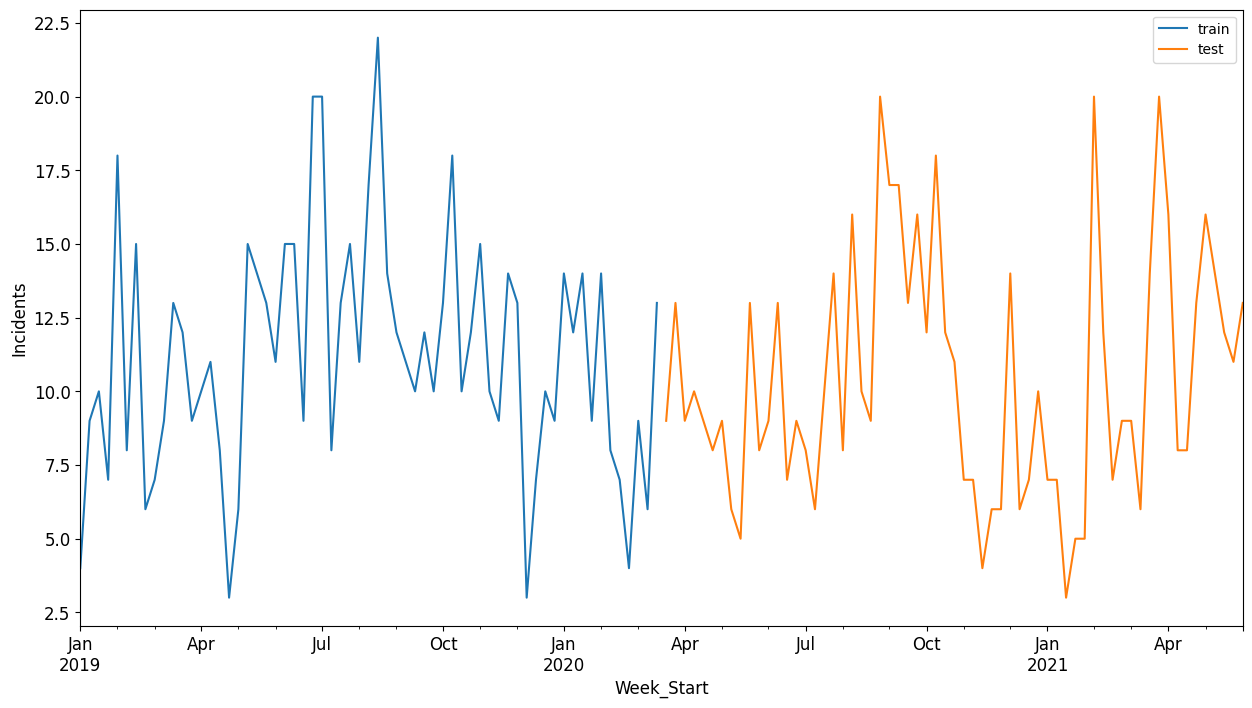

In [9]:
train_start_dt = '2019-01-01 00:00:00'
test_start_dt = '2020-03-19 00:00:00'  
Alldata = df.query('"2019-01-01 00:00:00" < Date < "2021-06-05 00:00:00"')
Alldata=Alldata.set_index('Date')
Alldata[(Alldata.index < test_start_dt) & (Alldata.index >= train_start_dt)][['Incidents']].rename(columns={'Incidents':'train'}) \
    .join(Alldata[test_start_dt:][['Incidents']].rename(columns={'Incidents':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('Week_Start', fontsize=12)
plt.ylabel('Incidents', fontsize=12)
plt.show()

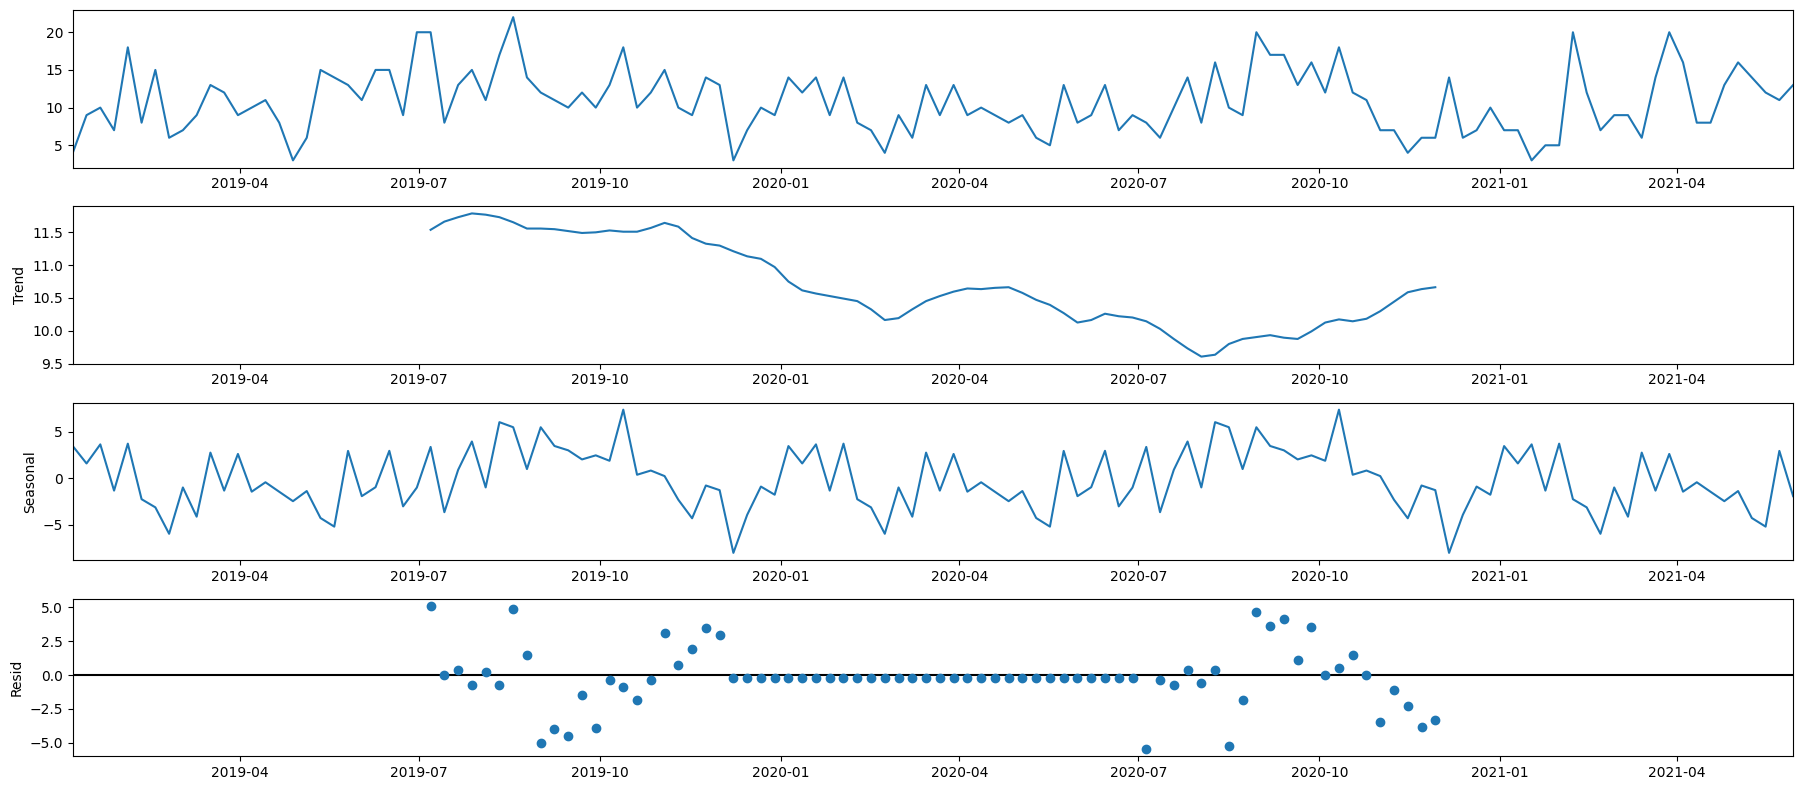

In [10]:
Alldata.drop(columns=['Week'], inplace=True)
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(Alldata)
fig = decomposition.plot()
plt.show()

In [11]:
train = Alldata.copy()[(Alldata.index >= train_start_dt) & (Alldata.index < test_start_dt)][['Incidents']]
test = Alldata.copy()[Alldata.index >= test_start_dt][['Incidents']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (63, 1)
Test data shape:  (63, 1)


In [12]:
scaler = MinMaxScaler()
train['Incidents'] = scaler.fit_transform(train)
train.head()

,Incidents
Date,
2019-01-06,0.05
2019-01-13,0.32
2019-01-20,0.37
2019-01-27,0.21
2019-02-03,0.79


,Incidents
Date,
2020-03-22,0.32
2020-03-29,0.53
2020-04-05,0.32
2020-04-12,0.37
2020-04-19,0.32


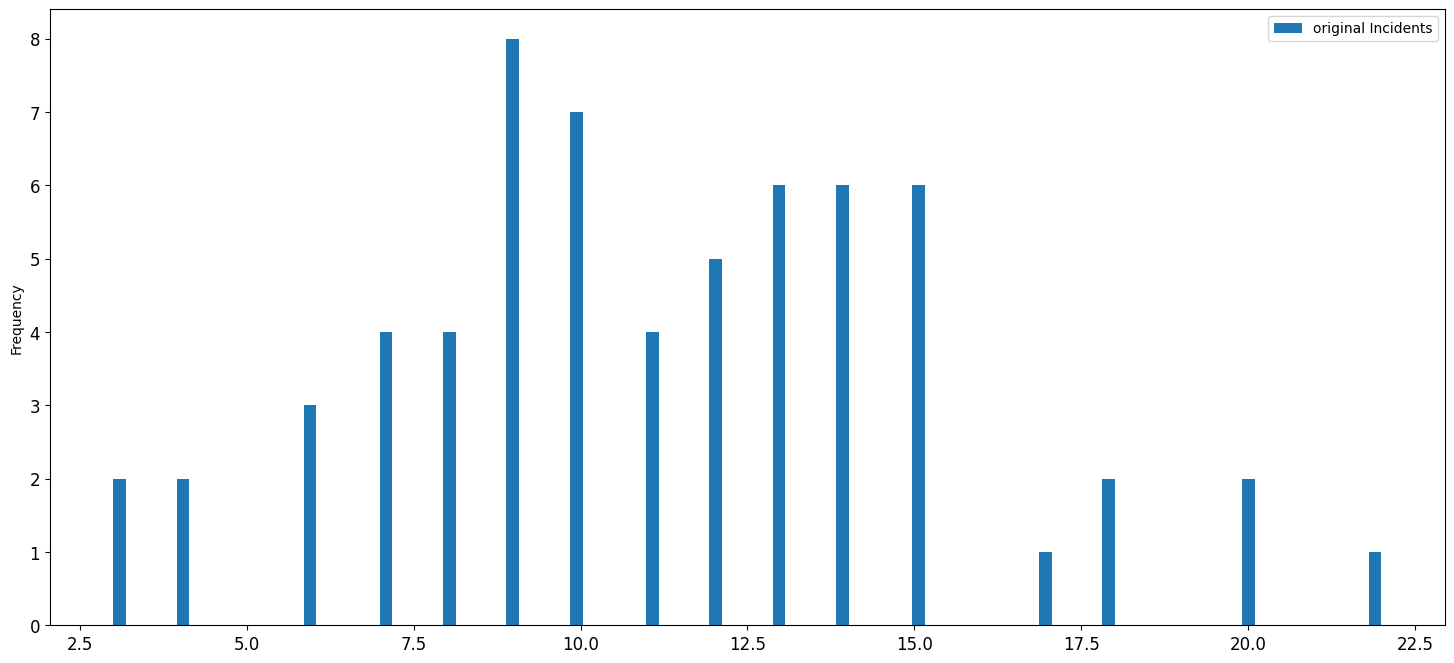

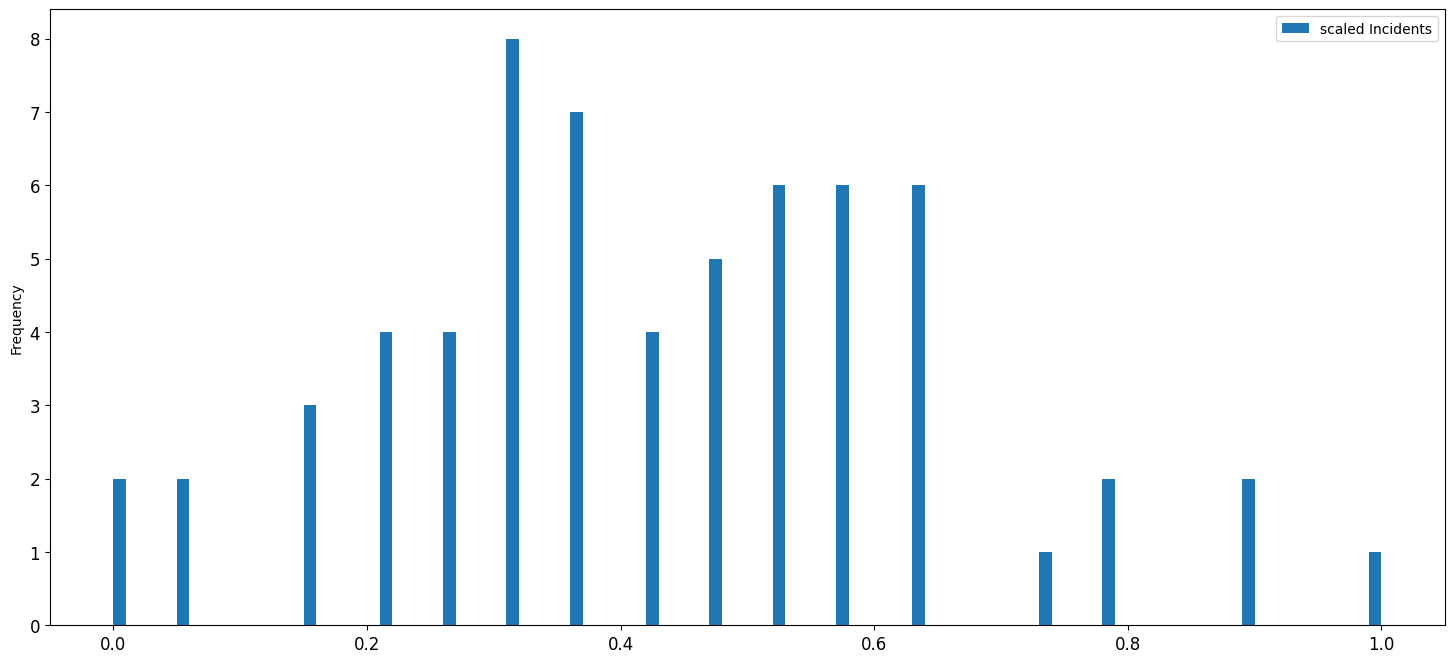

In [13]:
Alldata[(Alldata.index >= train_start_dt) & (Alldata.index < test_start_dt)][['Incidents']].rename(columns={'Incidents':'original Incidents'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'Incidents':'scaled Incidents'}).plot.hist(bins=100, fontsize=12)
test['Incidents'] = scaler.transform(test)
test.head()

In [14]:
# Specify the number of steps to forecast ahead
HORIZON = 4
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 6)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Incidents   No. Observations:                   63
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 6)   Log Likelihood                  -5.247
Date:                           Wed, 17 May 2023   AIC                             22.494
Time:                                   14:11:58   BIC                             34.646
Sample:                               01-06-2019   HQIC                            27.205
                                    - 03-15-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5309      0.145     -3.663      0.000      -0.815      -0.247
ar.L2         -0.5276      0.175     -3.008

In [15]:
test_shifted = test.copy()
test_shifted.head()

,Incidents
Date,
2020-03-22,0.32
2020-03-29,0.53
2020-04-05,0.32
2020-04-12,0.37
2020-04-19,0.32


In [16]:
for t in range(1, HORIZON): test_shifted['Incidents+'+str(t)] = test_shifted['Incidents'].shift(-t, freq='W')
test_shifted = test_shifted.dropna(how='any')
test_shifted.head()

,Incidents,Incidents+1,Incidents+2,Incidents+3
Date,,,,
2020-03-22,0.32,0.53,0.32,0.37
2020-03-29,0.53,0.32,0.37,0.32
2020-04-05,0.32,0.37,0.32,0.26
2020-04-12,0.37,0.32,0.26,0.32
2020-04-19,0.32,0.26,0.32,0.16


In [17]:
test_shifted=test_shifted.fillna(0.01)
test_shifted.tail()

,Incidents,Incidents+1,Incidents+2,Incidents+3
Date,,,,
2021-04-11,0.26,0.26,0.53,0.68
2021-04-18,0.26,0.53,0.68,0.58
2021-04-25,0.53,0.68,0.58,0.47
2021-05-02,0.68,0.58,0.47,0.42
2021-05-09,0.58,0.47,0.42,0.53


In [18]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['Incidents']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

# let's user simpler model for demonstration
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2020-03-22 00:00:00
1 : predicted = [0.39 0.22 0.25 0.61] expected = [0.3157894736842105, 0.5263157894736841, 0.3157894736842105, 0.3684210526315789]
2020-03-29 00:00:00
2 : predicted = [0.17 0.21 0.56 0.56] expected = [0.5263157894736841, 0.3157894736842105, 0.3684210526315789, 0.3157894736842105]
2020-04-05 00:00:00
3 : predicted = [0.4  0.69 0.75 0.61] expected = [0.3157894736842105, 0.3684210526315789, 0.3157894736842105, 0.2631578947368421]
2020-04-12 00:00:00
4 : predicted = [0.63 0.7  0.55 0.46] expected = [0.3684210526315789, 0.3157894736842105, 0.2631578947368421, 0.3157894736842105]
2020-04-19 00:00:00
5 : predicted = [0.52 0.4  0.28 0.52] expected = [0.3157894736842105, 0.2631578947368421, 0.3157894736842105, 0.15789473684210525]
2020-04-26 00:00:00
6 : predicted = [0.26 0.2  0.39 0.37] expected = [0.2631578947368421, 0.3157894736842105, 0.15789473684210525, 0.10526315789473684]
2020-05-03 00:00:00
7 : predicted = [ 0.2   0.4   0.37 -0.04] expected = [0.3157894736842105, 0.1

2021-04-11 00:00:00
56 : predicted = [0.58 0.45 0.6  0.4 ] expected = [0.2631578947368421, 0.2631578947368421, 0.5263157894736841, 0.6842105263157894]
2021-04-18 00:00:00
57 : predicted = [0.32 0.43 0.2  0.32] expected = [0.2631578947368421, 0.5263157894736841, 0.6842105263157894, 0.5789473684210527]
2021-04-25 00:00:00
58 : predicted = [0.4  0.15 0.27 0.34] expected = [0.5263157894736841, 0.6842105263157894, 0.5789473684210527, 0.47368421052631576]
2021-05-02 00:00:00
59 : predicted = [0.21 0.33 0.42 0.58] expected = [0.6842105263157894, 0.5789473684210527, 0.47368421052631576, 0.4210526315789474]
2021-05-09 00:00:00
60 : predicted = [0.55 0.63 0.84 0.58] expected = [0.5789473684210527, 0.47368421052631576, 0.4210526315789474, 0.5263157894736841]
CPU times: total: 1min 5s
Wall time: 39.3 s


In [19]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2020-03-22,t+1,10.46,9.00
1,2020-03-29,t+1,6.28,13.00
2,2020-04-05,t+1,10.61,9.00
3,2020-04-12,t+1,15.01,10.00
4,2020-04-19,t+1,12.96,9.00


In [20]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.43
t+2   0.46
t+3   0.48
t+4   0.53
Name: APE, dtype: float64


In [21]:
eval_df.tail()

,timestamp,h,prediction,actual,APE
235,2021-04-11,t+4,10.66,16.00,0.33
236,2021-04-18,t+4,9.06,14.00,0.35
237,2021-04-25,t+4,9.40,12.00,0.22
238,2021-05-02,t+4,13.93,11.00,0.27
239,2021-05-09,t+4,14.05,13.00,0.08


In [22]:
from sklearn.metrics import mean_absolute_percentage_error
Y_actual = eval_df['actual']
Y_Predicted = eval_df['prediction']
mean_absolute_percentage_error(Y_actual, Y_Predicted)

0.4782615471775703

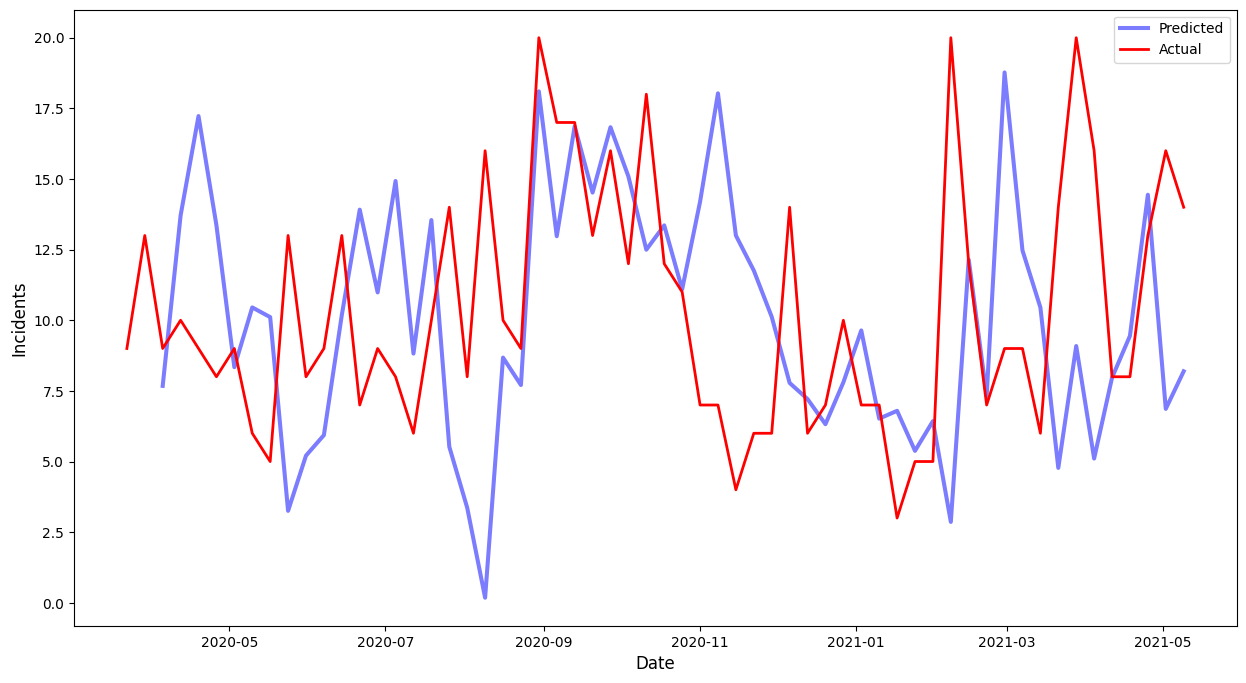

In [23]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(3, HORIZON):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    
    ax = fig.add_subplot(111)
    for t in range(3, HORIZON):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=2.0)
    
    
plt.xlabel('Date', fontsize=12)
plt.ylabel('Incidents', fontsize=12)
plt.legend(["Predicted", "Actual"], loc=0)
plt.show()

# Plotting predictions with confidence intervals

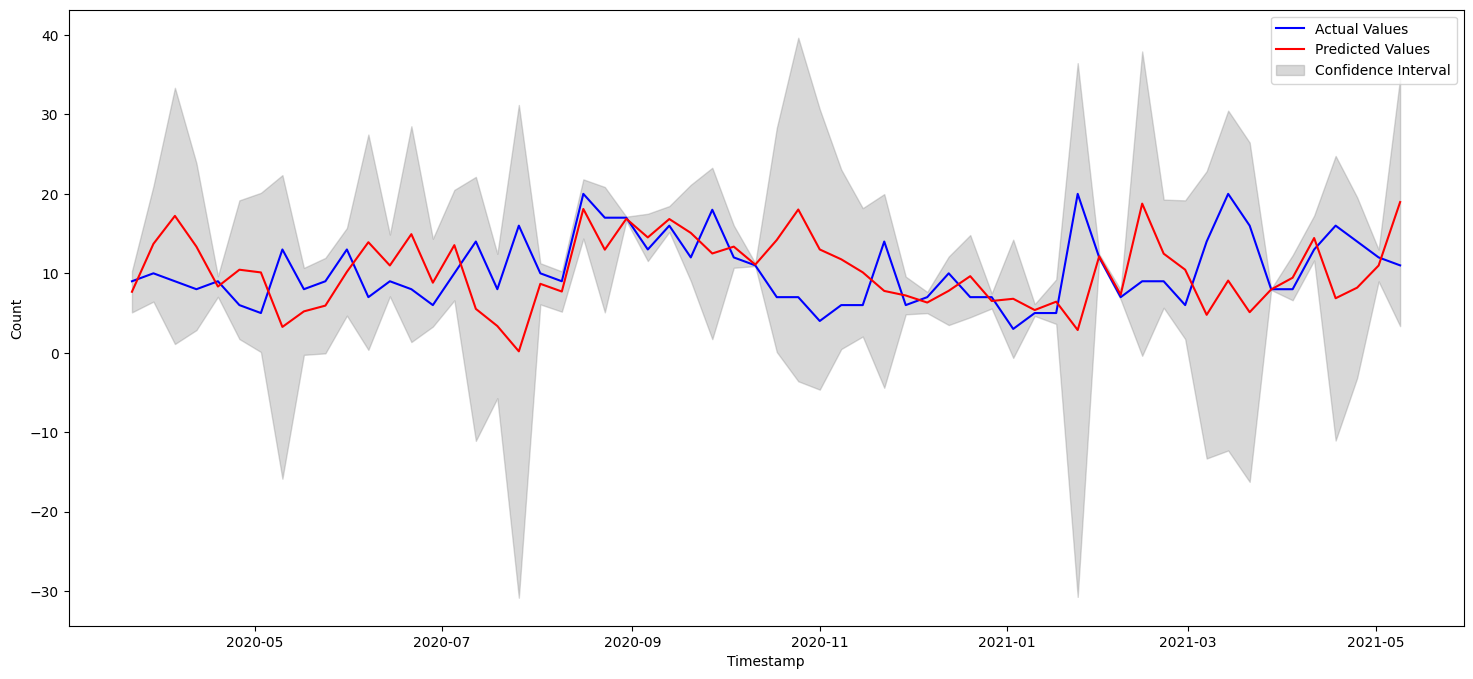

In [24]:
df = eval_df[eval_df['h'] == 't+3']
# Create a figure and axis for the plot
fig, ax = plt.subplots()
# Plot the actual values as a blue line
ax.plot(df['timestamp'], df['actual'], color='blue', label='Actual Values')

# Plot the predicted values as a red line
ax.plot(df['timestamp'], df['prediction'], color='red', label='Predicted Values')

# Calculate and plot the confidence interval as a shaded region
y_upper = df['prediction'] + 1.96 * df['APE'] * df['actual']
y_lower = df['prediction'] - 1.96 * df['APE'] * df['actual']
ax.fill_between(df['timestamp'], y_lower, y_upper, color='gray', alpha=0.3, label='Confidence Interval')

# Add a legend and axis labels
ax.legend()
ax.set_xlabel('Timestamp')
ax.set_ylabel('Count')

# Display the plot
plt.show()

# Prediction metrics

In [25]:
Y_actual = eval_df['actual']
Y_Predicted = eval_df['prediction']
print('MAPE: ', mean_absolute_percentage_error(Y_actual, Y_Predicted))

MAPE:  0.4782615471775703


In [27]:
#Symmetric Mean Absolute Percentage Error (sMAPE)
A = eval_df['actual']
F = eval_df['prediction']
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

print('SMAPE: ', smape(A, F))

SMAPE:  45.97317760658039


In [26]:
# Root Mean Squared Error (RMSE)
y_actual = eval_df['actual']
y_predicted = eval_df['prediction']
RMSE = math.sqrt(np.square(np.subtract(y_actual,y_predicted)).mean())
print("Root Mean Square Error:", RMSE)

Root Mean Square Error: 5.840156460740028


In [29]:
from sklearn.metrics import r2_score

Y_actual = eval_df['actual']
Y_predicted = eval_df['prediction']

R2 = r2_score(Y_actual, Y_predicted)
print("R2 Score:", R2)

R2 Score: 0.9089996620305256
